In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import timecorr as tc
import hypertools as hyp

%matplotlib inline

In [19]:
def normalize(x):
    x -= np.min(x)
    return np.divide(x, np.max(x))

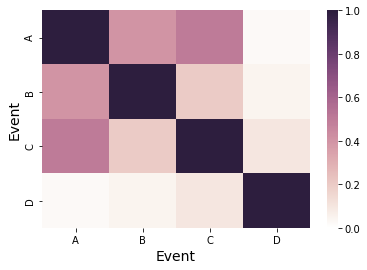

In [20]:
memories = np.array(['A', 'B', 'C', 'D'])
starts = np.array([-500, -350, -200, -100])
durations = np.array([50, 40, 20, 25])
ts = np.arange(-650, 0, 0.1)
corrmat = np.zeros([len(memories), len(memories)])

#add some interesting covariance structure
corrmat[memories == 'A', memories == 'B'] = 0.4
corrmat[memories == 'A', memories == 'C'] = 0.5
corrmat[memories == 'B', memories == 'C'] = 0.2
corrmat[memories == 'A', memories == 'D'] = 0.025
corrmat[memories == 'B', memories == 'D'] = 0.05
corrmat[memories == 'C', memories == 'D'] = 0.1
corrmat += corrmat.T
np.fill_diagonal(corrmat, 1.)

ax = sns.heatmap(corrmat, cmap=sns.cubehelix_palette(light=True, as_cmap=True), vmin=0., vmax=1.);
ax.set_xlabel('Event', fontsize=14);
ax.set_ylabel('Event', fontsize=14);
ax.set_xticklabels(memories);
ax.set_yticklabels(memories);
plt.savefig('corrmat.pdf')

In [21]:
def raw(ts, start, duration):
    x = np.zeros_like(ts)
    x[(ts >= start) & (ts <= start+duration)] = 1.
    return x

def delta(ts, start, duration):
    x = np.zeros_like(ts)
    x[np.isclose(ts, start)] = 1.
    return x

def gaussian(ts, start, duration):
    return norm.pdf(ts, loc=start + (duration / 2.), scale=duration)

def drift(ts, start, duration, tau=0.95):
    x = raw(ts, start, duration)
    for i in np.where(ts > start+duration)[0]:
        if i <= 0:
            continue
        elif np.isclose(x[i-1], 0):
            break
        dt = ts[i] - ts[i-1]
        x[i] = x[i-1] - ((1 - tau) * x[i-1])*dt
    return x

In [22]:
def mix(ts, starts, durations, coeffs, activity_function):
    x = np.zeros_like(ts)
    for i in np.arange(len(starts)):
        if coeffs[i] <= 0:
            continue
        x += np.multiply(coeffs[i], activity_function(ts, starts[i], durations[i]))
    return x

In [23]:
def plot_mixture(ts, starts, durations, coeffs, activity_function):
    x = normalize(mix(ts, starts, durations, coeffs, activity_function))
    ax = plt.plot(ts, x)
    plt.xlabel('Time (arbitrary units)', fontsize=14)
    plt.ylabel('Activity match', fontsize=14)
    plt.xticks(np.hstack((np.min(ts), starts, np.max(ts))), np.hstack(('Distant past', memories, '$\cdots$')), fontsize=12)
    plt.yticks([0.0, 0.5, 1.0], fontsize=12)
    plt.xlim([np.min(ts), np.max(ts)])
    plt.ylim([0, 1])    

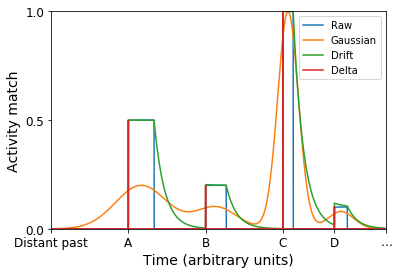

In [24]:
plot_mixture(ts, starts, durations, corrmat[memories == 'C', :][0], raw)
plot_mixture(ts, starts, durations, corrmat[memories == 'C', :][0], gaussian)
plot_mixture(ts, starts, durations, corrmat[memories == 'C', :][0], drift)
plot_mixture(ts, starts, durations, corrmat[memories == 'C', :][0], delta)
plt.legend(['Raw', 'Gaussian', 'Drift', 'Delta'])
plt.savefig('reinstatement.pdf')

In [25]:
def plot_memory(ts, starts, durations, mem, activity_function):
    coeffs = np.int8(memories == mem)
    plot_mixture(ts, starts, durations, coeffs, activity_function)

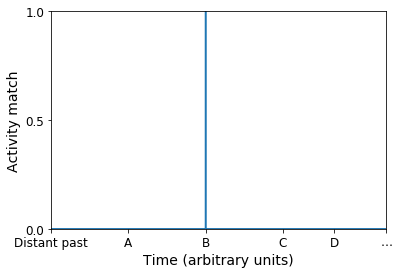

In [26]:
activity_functions = [raw, gaussian, drift, delta]
for a in activity_functions:
    plt.clf()
    plot_memory(ts, starts, durations, 'B', a)
    plt.savefig(a.__name__ + '.pdf')

In [27]:
D = 10 #number of activity dimensions
ts = np.arange(-650, 0, 0.5)
chol_full = np.zeros([len(ts), len(ts)])
chol = np.linalg.cholesky(corrmat)
corr_full = np.zeros_like(chol_full)
for i in np.arange(len(memories)):
    #mystery: why can't I use logical indexing directly?  e.g. `corrs[row_inds, :][:, col_inds] = corrmat[i, j]`?
    row_inds = np.where((ts >= starts[i]) & (ts <= (starts[i] + durations[i])))[0]
    rs = np.min(row_inds)
    re = np.max(row_inds)
    for j in np.arange(len(memories)):
        col_inds = np.where((ts >= starts[j]) & (ts <= (starts[j] + durations[j])))[0]
        cs = np.min(col_inds)
        ce = np.max(col_inds)
        
        chol_full[rs:re, :][:, cs:ce] = chol[i, j]
        corr_full[rs:re, :][:, cs:ce] = corrmat[i, j]
np.fill_diagonal(corr_full, 1.)

In [114]:
#generate random autocorrelated data
# - first generate an autocorrelated timeseries with D rows and len(ts) columns (autocorrelated along axis=1)
# - then use the cholesky decomposition of corrs to make the columns correlated
# - then set the data to the transpose of the transformed timeseries
#x = np.cumsum(np.random.randn(len(ts), D), axis=0)
x = np.random.randn(len(ts), D)

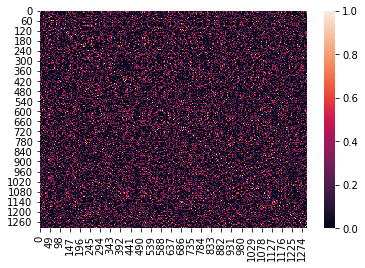

In [115]:
sns.heatmap(np.corrcoef(x), vmin=0, vmax=1)

In [116]:
#snip out zeros
zero_inds = np.sum(np.isclose(chol_full, 0), axis=0) == corr_full.shape[0]

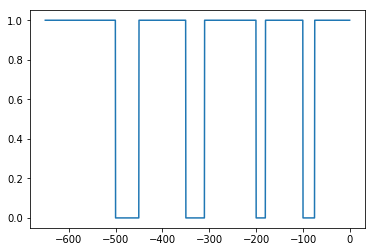

In [117]:
plt.plot(ts, zero_inds)

In [118]:
corr_x = x[~zero_inds, :]
chol_nonzero = chol_full[~zero_inds, :][:, ~zero_inds]
corr_nonzero = corr_full[~zero_inds, :][:, ~zero_inds]

In [119]:
y = np.dot(chol_nonzero, corr_x)

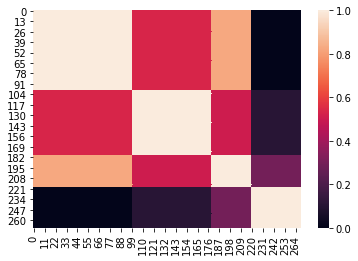

In [120]:
#sns.heatmap(np.corrcoef(y + np.multiply(1000, np.random.randn(y.shape[0], y.shape[1]))), vmin=0, vmax=1)
sns.heatmap(np.corrcoef(y), vmin=0, vmax=1)

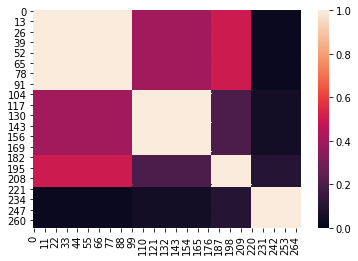

In [121]:
sns.heatmap(corr_nonzero, vmin=0, vmax=1)

In [122]:
x[~zero_inds, :] = y

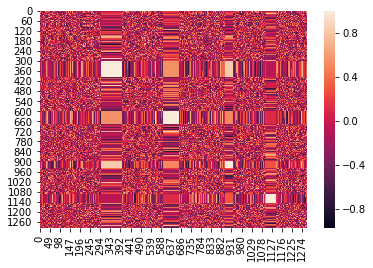

In [123]:
sns.heatmap(np.corrcoef(x))

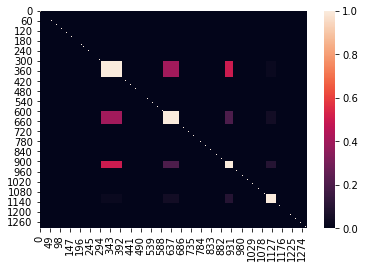

In [124]:
sns.heatmap(corr_full)

In [125]:
def resort_labels(x):
    inds = np.unique(x, return_index=True)[1]
    unique_x = [x[i] for i in sorted(inds)]
    y = np.zeros_like(x)
    for i in np.arange(len(unique_x)):
        y[x == unique_x[i]] = i
    return y

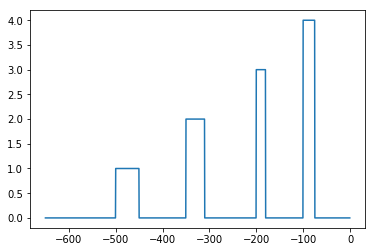

In [127]:
clusters = hyp.cluster(x, cluster='KMeans', n_clusters=len(memories)+1)
plt.plot(ts, resort_labels(clusters))

In [128]:
x_reduced = hyp.reduce(x, reduce='UMAP', ndims=2)
colors = sns.cubehelix_palette(len(np.unique(clusters)))

In [129]:
def bounding_box(x, border=0.1):
    minval = np.min(x)
    maxval = np.max(x)
    
    minval -= np.multiply(border, np.abs(minval))
    maxval += np.multiply(border, np.abs(maxval))
    
    return plt.plot([minval, minval, maxval, maxval, minval], [minval, maxval, maxval, minval, minval], 'k-')

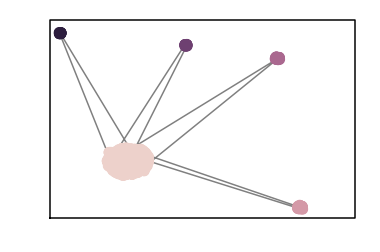

In [130]:
plt.clf()
ax = plt.plot(x_reduced[:, 0], x_reduced[:, 1], '-', color=[0.5, 0.5, 0.5], zorder=0)
ax = plt.scatter(x_reduced[:, 0], x_reduced[:, 1], s=100, c=np.asarray(colors)[clusters, :], zorder=1)
ax = bounding_box(x_reduced)
plt.axis('off');
plt.savefig('state_trajectory.pdf')

In [131]:
def raw_integrator(ts, x):
    return x

def gaussian_integrator(ts, x, width=50):
    dt = ts[1] - ts[0]
    kernel = normalize(norm.pdf(np.arange(0, 25, dt), loc=np.mean(ts), scale=width))
    return np.convolve(x, kernel, 'same')

def drift_integrator(ts, x, tau=0.95):
    dt = ts[1] - ts[0]
    y = np.copy(x)
    for i in np.arange(1, len(x)):
        y[i] = x[i] + y[i-1] - ((1 - tau) * y[i-1])*dt
    return y
        
def mutate(ts, x, method):
    y = np.copy(x)
    for i in np.arange(x.shape[1]):
        y[:, i] = method(ts, x[:, i])
    return y

def plot_mutated(ts, x, method):
    m = normalize(mutate(ts, x, method))
    colors = sns.cubehelix_palette(x.shape[1])
    for i in np.arange(x.shape[1]):
        plt.plot(ts, m[:, i], color=colors[i])
    plt.xlabel('Time (arbitrary units)', fontsize=14)
    plt.ylabel('Activity (arbitrary units)', fontsize=14)
    plt.xlim([np.min(ts), np.max(ts)])
    plt.ylim([np.min(m), np.max(m)])
    plt.savefig(method.__name__ + '.pdf')

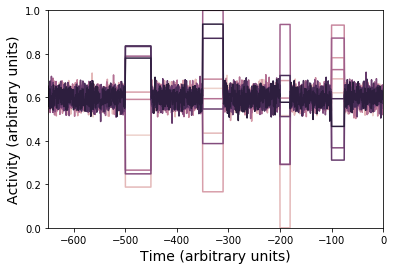

In [132]:
plot_mutated(ts, x, raw_integrator)

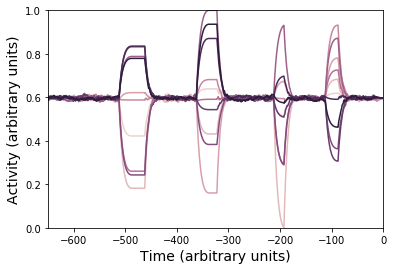

In [133]:
plot_mutated(ts, x, gaussian_integrator)

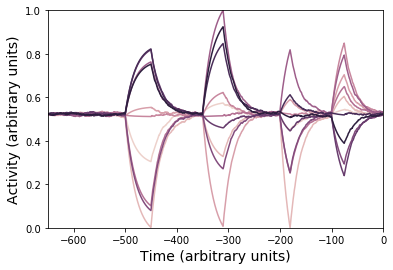

In [136]:
plot_mutated(ts, x, drift_integrator)

To do and/or think about:
- Should activity look similar to "Now" event?
- Simulate data that conform to the different timeseries (both for "mixture" and "single event reinstatement" models)
- Plot correlation matrices under different assumptions
  - Use x as the "template" and then blur it out using the different models (delta/raw = no blur; gaussian = convolve with gaussian; drift = y[t] = x[t] + tau*y[t-1]
- Simulate recall: recall event + random gaussian noise (modified to fit each model)
- Do event segmentation?
- Plot recalls with Quail-naturalistic?

Key question this is trying to answer: what does memory look like if the world and our brain representations are changing under different models?